In [1]:
#Import Python modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import trimesh
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import copy


In [2]:
#Import model modules
import Data_loader_final as dl
import evaluation as ev
import Iterative_PCA_Model as ipca
import SGC as SGC

In [3]:
random_state=42
np.random.seed(random_state)

In [4]:
#Useful functions

def compute_error(X_reconstructed, X_original):
    return np.linalg.norm(X_reconstructed - X_original) / X_original.size

def error_mesh(mesh_reconstructed, mesh_original):
    errors = np.mean((mesh_reconstructed.vertices - mesh_original.vertices)**2, axis=1)
    errors_norm = (errors - errors.min()) / (errors.max() - errors.min())

    cmap = plt.get_cmap("jet")
    colors = (cmap(errors_norm)[:, :3] * 255).astype(np.uint8)

    mesh_error = trimesh.Trimesh(
        vertices=mesh_reconstructed.vertices,
        faces=mesh_reconstructed.faces,
        vertex_colors=colors
    )

    return mesh_error, errors

def plot_colorbar(errors):
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    cmap = plt.get_cmap("jet")
    norm = plt.Normalize(vmin=0, vmax=1)

    cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                       cax=ax, orientation='horizontal')
    cb1.set_label('Reconstruction Error Norm')
    plt.show()

def build_mask(mat_vertices, missing_rate=0.3, random=True, pca_mode=True):
    N, M, _ = mat_vertices.shape
    mask = np.zeros((N, M), dtype=bool)
    
    if random or pca_mode:
        mask = np.random.random((N, M)) < missing_rate
        if pca_mode:
            # Ensure at least one observed value per column
            observed_per_col = (~mask).sum(axis=0)
            missing_cols = np.where(observed_per_col == 0)[0]
            mask[np.random.randint(N, size=len(missing_cols)), missing_cols] = False

    else:
        n_missing = int(M * missing_rate)
        mask[:, :n_missing] = True
    
    print(f"Number of missing values: {mask.sum()} out of {N*M} ({100 * mask.sum() / (N*M):.2f}%)")
    return mask


def one_augmentation(mat_vertices):
    N, M, D = mat_vertices.shape
    mat_vertices_augmented = np.zeros((N, M,  D + 1))
    mat_vertices_augmented[:, :M, :D] = mat_vertices
    mat_vertices_augmented[:, M:, 0] = 1.0  # Augmentation channel
    return mat_vertices_augmented

def remove_one_augmentation(mat_vertices_augmented):
    N, M_augmented, D_augmented = mat_vertices_augmented.shape
    D = D_augmented - 1
    mat_vertices = mat_vertices_augmented[:, :M_augmented, :D]
    return mat_vertices

In [6]:
# Chargement des données
data_path="data"
meshes = dl.load_meshes(data_path)

Loaded 24 meshes from data


# Clusterisation de détection des points anatomiques (Exemple Data Augmentation)

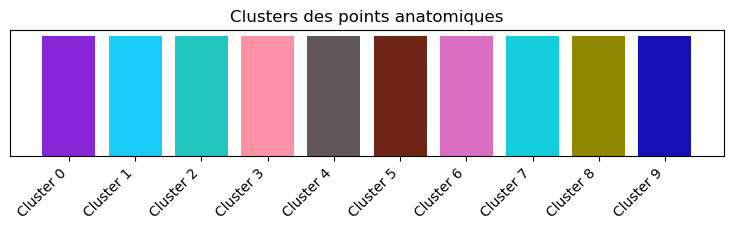

In [7]:
# Détection des points anatomiques
#centroids = dl.detect_anatomical_points(meshes, n_clusters=25, random_state=random_state)
centroids = dl.detect_anatomical_points(meshes, n_clusters=10, random_state=random_state)

# Coloration du mesh
index_to_plot = 0
mesh_colored, labels = dl.color_mesh_by_centroids(meshes[index_to_plot], centroids)

# Récupérer les couleurs de chaque cluster depuis mesh_colored
cluster_colors = np.array([mesh_colored.visual.vertex_colors[labels == i][0] for i in range(centroids.shape[0])]) / 255.0

# Afficher la légende
dl.plot_cluster_legend(cluster_colors, n_cols=5, title="Clusters des points anatomiques")

# Affichage du mesh
mesh_colored.show()

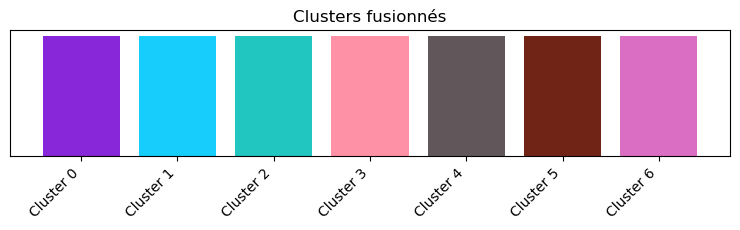

In [8]:
# Fusion de certains clusters
head_clusters = [0]
lesser_trochanter_clusters = [9]
greater_trochanter_clusters = [5]
body_clusters = [1,2,4,6]
popliteal_patellar_surface_clusters = [8]  
medial_condyle_clusters = [7]  
lateral_condyle_clusters = [3] 

merge_list = [head_clusters,
              lesser_trochanter_clusters,
              greater_trochanter_clusters,
              body_clusters,
              popliteal_patellar_surface_clusters,
              medial_condyle_clusters,
              lateral_condyle_clusters]

mesh_merged, new_labels = dl.merge_clusters(meshes[index_to_plot], labels, merge_list, random_state=random_state)

# Récupérer uniquement les labels présents
unique_labels = np.unique(new_labels)

# Récupérer la couleur pour chaque label présent
new_cluster_colors = np.array([mesh_merged.visual.vertex_colors[new_labels == i][0] 
                               for i in unique_labels]) / 255.0

# Plot légende
dl.plot_cluster_legend(new_cluster_colors, title="Clusters fusionnés")

# Affichage du mesh fusionné
mesh_merged.show()

In [9]:
# Déformations de base par région
region_deformations = {
    "head":                       {"factor": 1.02, "radius": 0.2, "intensity": 0.05, "angle": np.pi/36},
    "lesser_trochanter":          {"factor": 1, "radius": 0.08, "intensity": 0.03, "angle": np.pi/36},
    "greater_trochanter":         {"factor": 1.02, "radius": 0.1, "intensity": 0.03, "angle": np.pi/36},
    "body":                        {"factor": 1, "radius": 0.40, "intensity": 0.1, "angle": np.pi/36},
    "popliteal_patellar_surface": {"factor": 1, "radius": 0.20, "intensity": 0.05, "angle": np.pi/36},
    "medial_condyle":             {"factor": 1.02, "radius": 0.1, "intensity": 0.05, "angle": np.pi/36},
    "lateral_condyle":            {"factor": 1.02, "radius": 0.1, "intensity": 0.05, "angle": np.pi/36},
}

region_map = {
    "head":                       0,
    "lesser_trochanter":          1,
    "greater_trochanter":         2,
    "body":                        3,
    "popliteal_patellar_surface": 4,
    "medial_condyle":             5,
    "lateral_condyle":            6,
}


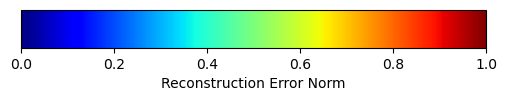

Reconstruction Loss: 0.000012


In [10]:
mesh_to_deform = meshes[index_to_plot]
labels_to_use = new_labels  # si new_labels correspond bien au mesh choisi

# Calcul automatique des centres anatomiques (par région)
region_centers = dl.compute_region_centers(
    mesh_to_deform,
    labels_to_use,
    region_map,
    n_centers_per_region=1
)

# Déformation avec centres
mesh_deformed = dl.deform_mesh_by_regions(
    mesh_to_deform,
    labels_to_use,
    region_deformations,
    region_map,
    region_centers=region_centers,
    random_state=random_state,
)

# Visualisation
mesh_error, errors_color = error_mesh(mesh_deformed, mesh_to_deform)
plot_colorbar(errors_color)
recon_loss = ev.ReconstructionLoss()
print(f"Reconstruction Loss: {recon_loss(torch.tensor(mesh_deformed.vertices), torch.tensor(mesh_to_deform.vertices)).item():.6f}")
mesh_error.show()


# Split des données et Augmentation sur le train et val

In [11]:
# -------------------------------------------------------------------
# 1. Split des meshes
# -------------------------------------------------------------------
train_ratio = 0.6
val_ratio   = 0.2
test_ratio  = 0.2

train_mesh, val_mesh, test_mesh = dl.create_splits(
    meshes,
    split_ratios=(train_ratio, val_ratio, test_ratio),
    random_state=random_state
)

print("Shapes des données :")
print(f"Train: {len(train_mesh)} meshes")
print(f"Val: {len(val_mesh)} meshes")
print(f"Test: {len(test_mesh)} meshes")

# -------------------------------------------------------------------
# 2. Calcul des labels pour chaque mesh
# -------------------------------------------------------------------
# Exemple : new_labels_list[i] = labels pour le i-ème mesh
train_labels_list = [new_labels for mesh in train_mesh]  # <-- remplacer par labels réels
val_labels_list   = [new_labels for mesh in val_mesh]    # <-- remplacer par labels réels

# -------------------------------------------------------------------
# 3. Augmentation via deform_mesh_by_regions
# -------------------------------------------------------------------
augmentation = True
if augmentation:
    print("Augmentation des données via augment_meshes...")

    train_factor = 50
    val_factor   = 50

    # Augmentation train
    train_mesh = dl.augment_meshes(
        train_mesh,
        train_labels_list,
        region_deformations,
        region_map,
        num_augmented=train_factor,
        random_state=random_state
    )

    # Augmentation val
    val_mesh = dl.augment_meshes(
        val_mesh,
        val_labels_list,
        region_deformations,
        region_map,
        num_augmented=val_factor,
        random_state=random_state+1
    )

print(f"Nombre de meshes dans le train: {len(train_mesh)}")
print(f"Nombre de meshes dans le val: {len(val_mesh)}")
print(f"Nombre de meshes dans le test: {len(test_mesh)}")


Splits: train=14, val=4, test=6
Shapes des données :
Train: 14 meshes
Val: 4 meshes
Test: 6 meshes
Augmentation des données via augment_meshes...
Nombre de meshes dans le train: 700
Nombre de meshes dans le val: 200
Nombre de meshes dans le test: 6


In [12]:
#Affichage d'un mesh
index_to_plot = 2
train_mesh[index_to_plot].show()  # Affiche le premier mesh du train

# Filtrage éventuel si déformations trop brusques

In [13]:
# #Conversion des meshes en Graphes
# train_graphs = dl.meshes_to_data(train_mesh, mode="graph")
# val_graphs   = dl.meshes_to_data(val_mesh, mode="graph")
# test_graphs  = dl.meshes_to_data(test_mesh, mode="graph")

In [14]:
# #Filtrage des variations brusques par SGC

# #Décommenter au 1er run

# sgc_model = SGC.SGC_model()
# sgc_model.fit(train_graphs, latent_dim=500, verbose=False)

In [15]:
# sgc_model.filter_dataset(train_graphs)
# train_mesh_filtered = dl.data_to_mesh(train_graphs, mode="graph", faces=meshes[0].faces)

# sgc_model.filter_dataset(val_graphs)
# val_mesh_filtered = dl.data_to_mesh(val_graphs, mode="graph", faces=meshes[0].faces)

In [16]:
# #Affichage d'un mesh
# index_to_plot = 2
# train_mesh_filtered[index_to_plot].show()  # Affiche le premier mesh du train

In [17]:
# #Conversion en matrices numpy applatie pour PCA
# train_vertices = dl.meshes_to_data(train_mesh_filtered, mode="flat")
# val_vertices = dl.meshes_to_data(val_mesh_filtered, mode="flat")
# test_vertices = dl.meshes_to_data(test_mesh, mode="flat")

# train_vertices = np.array([x.numpy() for x in train_vertices])
# val_vertices = np.array([x.numpy() for x in val_vertices])
# test_vertices = np.array([x.numpy() for x in test_vertices])

# print("Shape des données:")
# print(f"Train: {train_vertices.shape}")
# print(f"Val: {val_vertices.shape}")
# print(f"Test: {test_vertices.shape}")

# I. Espace Latent

# PCA

In [18]:
#Conversion en matrices numpy applatie pour PCA
train_vertices = dl.meshes_to_data(train_mesh, mode="flat")
val_vertices = dl.meshes_to_data(val_mesh, mode="flat")
test_vertices = dl.meshes_to_data(test_mesh, mode="flat")

train_vertices = np.array([x.numpy() for x in train_vertices])
val_vertices = np.array([x.numpy() for x in val_vertices])
test_vertices = np.array([x.numpy() for x in test_vertices])

print("Shape des données:")
print(f"Train: {train_vertices.shape}")
print(f"Val: {val_vertices.shape}")
print(f"Test: {test_vertices.shape}")

Shape des données:
Train: (700, 54873)
Val: (200, 54873)
Test: (6, 54873)


# Classical PCA

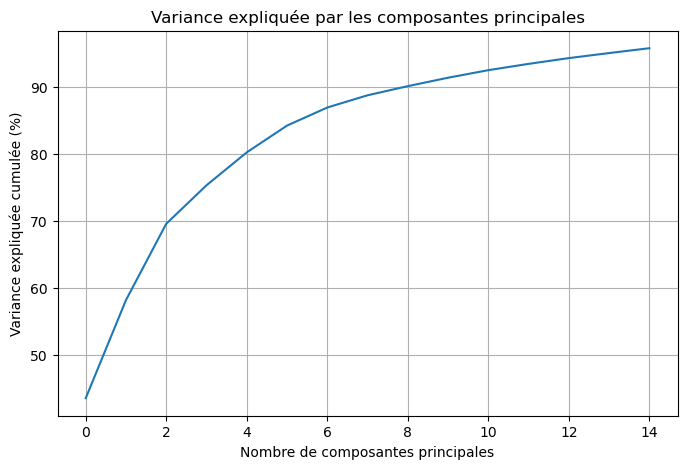

In [19]:
pca_model = ipca.Iterative_PCA(n_components=0.95, random_state=random_state)
pca_model.fit_filled(train_vertices)
pca_model.plot_explained_variance()

Mesh 0 - Reconstruction Loss: 0.000028
Mesh 1 - Reconstruction Loss: 0.000044
Mesh 2 - Reconstruction Loss: 0.000013
Mesh 3 - Reconstruction Loss: 0.000026
Mesh 4 - Reconstruction Loss: 0.000050
Mesh 5 - Reconstruction Loss: 0.000040
Worst reconstruction error is for mesh 4 with error 0.000050


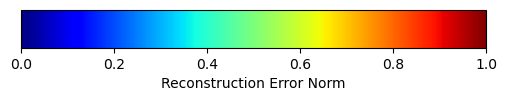

In [20]:
#Forward pass on test set
test_vertices_latent = pca_model.transform(test_vertices)
latent = torch.tensor(test_vertices_latent, dtype=torch.float32)
test_vertices_reconstructed = pca_model.inverse_transform(test_vertices_latent)

test_meshes_reconstructed = dl.data_to_mesh(
    [torch.tensor(v) for v in test_vertices_reconstructed],
    mode="flat",
    faces=meshes[0].faces
)

evaluator = ev.MeshReconstructionEvaluator(num_vertices=meshes[0].vertices.shape[0])
worst_error = -1
worst_mesh_index = -1

for i in range(len(test_mesh)):
    mesh_reconstructed = test_meshes_reconstructed[i]
    mesh_original = test_mesh[i]
    
    recon_loss = ev.ReconstructionLoss()
    error = recon_loss(torch.tensor(mesh_reconstructed.vertices), torch.tensor(mesh_original.vertices)).item()
    print(f"Mesh {i} - Reconstruction Loss: {error:.6f}")
    

    if error > worst_error:
        worst_error = error
        worst_mesh_index = i

print(f"Worst reconstruction error is for mesh {worst_mesh_index} with error {worst_error:.6f}")
mesh_error, errors_color = error_mesh(test_meshes_reconstructed[worst_mesh_index], test_mesh[worst_mesh_index])

plot_colorbar(errors_color)
mesh_error.show()

# One Augmented PCA

# Barycenter Augmented PCA

# Kernel PCA

# SGC

# VAE

# RESULTS

# II. Inférence

# PCA

# Gaussian Inference

# VAE

# RESULTS